In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier


cc2 = pd.read_csv('chapter_2/creditcard_sampledata_2.csv')
df = pd.DataFrame(cc2)

In [2]:
df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,...,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,...,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,...,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,...,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,...,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [3]:
df.shape

(7300, 31)

In [4]:
X = df.drop('Class', axis=1)
y = df['Class']

In [5]:
total_obs = len(y)
total_obs

non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

percentage = (float(count_non_fraud)/ float(total_obs)) * 100
percentage

95.8904109589041

In [6]:
# split dataset into train and test

train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.3)

# build model without any parameter tuning
random_forest = RandomForestClassifier(random_state=5)
random_forest.fit(train_X, train_Y)
prediction = random_forest.predict(test_X)


In [7]:
# performance metrics
probs = random_forest.predict_proba(test_X)
print("Accuracy score:\n", accuracy_score(test_Y, prediction))
print("Classification_report:\n",classification_report(test_Y, prediction))
print("AUC Score:\n",roc_auc_score(test_Y, probs[:, 1]))
print("Confusion Matrix:\n",confusion_matrix(test_Y, prediction))


Accuracy score:
 0.991324200913242
Classification_report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2094
           1       1.00      0.80      0.89        96

    accuracy                           0.99      2190
   macro avg       1.00      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

AUC Score:
 0.975308918338109
Confusion Matrix:
 [[2094    0]
 [  19   77]]


In [8]:
def plot_pr_curve(recall, precision, average_precision):
    """
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    """
    from inspect import signature
    plt.figure()
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.0])
    plt.xlim([0.0, 1.0])
    plt.title(f'2-class Precision-Recall curve: AP={average_precision:0.2f}')
    return plt.show()

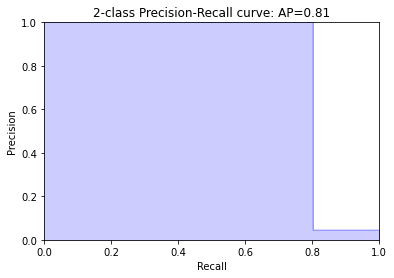

In [9]:
# average precison and precison recal curve

average_precision = average_precision_score(test_Y, prediction)
precision, recall, _ = precision_recall_curve(test_Y, prediction)

plot_pr_curve(recall, precision, average_precision)

In [10]:
# model adjustments
rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)
model = rf.fit(train_X, train_Y)

predicted = model.predict(test_X)
probs = model.predict_proba(test_X)

print("Accuracy score:\n", accuracy_score(test_Y, predicted))
print("Classification_report:\n",classification_report(test_Y, predicted))
print("AUC Score:\n",roc_auc_score(test_Y, probs[:, 1]))
print("Confusion Matrix:\n",confusion_matrix(test_Y, predicted))

Accuracy score:
 0.9908675799086758
Classification_report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2094
           1       1.00      0.79      0.88        96

    accuracy                           0.99      2190
   macro avg       1.00      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

AUC Score:
 0.9657876671442216
Confusion Matrix:
 [[2094    0]
 [  20   76]]


In [11]:
# gridsearch to find optimal parameters

param_grid = {
    'n_estimators': [1, 30],
    'max_features': ['auto', 'log2'],
    'max_depth': [4, 8],
    'criterion': ['gini', 'entropy']
}

rf2 = RandomForestClassifier(random_state=5)

cv_model = GridSearchCV(estimator=rf2, param_grid=param_grid, cv=5, scoring='recall')
cv_model.fit(train_X, train_Y)
cv_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 30}

In [12]:
# new model 
model = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_features='log2', 
            n_estimators=30, max_depth=8, min_samples_leaf=10, random_state=5)
model.fit(train_X, train_Y)

predicted = model.predict(test_X)
probs = model.predict_proba(test_X)

print("Accuracy score:\n", accuracy_score(test_Y, predicted))
print("Classification_report:\n",classification_report(test_Y, predicted))
print("AUC Score:\n",roc_auc_score(test_Y, probs[:, 1]))
print("Confusion Matrix:\n",confusion_matrix(test_Y, predicted))

Accuracy score:
 0.9917808219178083
Classification_report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2094
           1       0.99      0.82      0.90        96

    accuracy                           0.99      2190
   macro avg       0.99      0.91      0.95      2190
weighted avg       0.99      0.99      0.99      2190

AUC Score:
 0.9629745702005731
Confusion Matrix:
 [[2093    1]
 [  17   79]]


In [13]:
logit = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
logit.fit(train_X, train_Y)

predicted = logit.predict(test_X)
probs = logit.predict_proba(test_X)

print("Accuracy score:\n", accuracy_score(test_Y, predicted))
print("Classification_report:\n",classification_report(test_Y, predicted))
print("AUC Score:\n",roc_auc_score(test_Y, probs[:, 1]))
print("Confusion Matrix:\n",confusion_matrix(test_Y, predicted))

Accuracy score:
 0.9616438356164384
Classification_report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98      2094
           1       0.54      0.85      0.66        96

    accuracy                           0.96      2190
   macro avg       0.77      0.91      0.82      2190
weighted avg       0.97      0.96      0.97      2190

AUC Score:
 0.9592237742757085
Confusion Matrix:
 [[2024   70]
 [  14   82]]


In [14]:
# ENSEMBLE METHOD

clf1 = logit
clf2 = model
clf3 = DecisionTreeClassifier(class_weight='balanced', random_state=5)

# you can remove weights and change voting to hard
ensemble_model = VotingClassifier(estimators=[('lr', logit), ('rf', model), ('dt', clf3)], weights=[1, 4, 1], voting='soft') 

ensemble_model.fit(train_X, train_Y)

predicted = ensemble_model.predict(test_X)
#probs = ensemble_model.predict_proba(test_X)

print("Accuracy score:\n", accuracy_score(test_Y, predicted))
print("Classification_report:\n",classification_report(test_Y, predicted))
#print("AUC Score:\n",roc_auc_score(test_Y, probs[:, 1]))
print("Confusion Matrix:\n",confusion_matrix(test_Y, predicted))

Accuracy score:
 0.991324200913242
Classification_report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      2094
           1       0.98      0.82      0.89        96

    accuracy                           0.99      2190
   macro avg       0.98      0.91      0.94      2190
weighted avg       0.99      0.99      0.99      2190

Confusion Matrix:
 [[2092    2]
 [  17   79]]
